In [ ]:
%pip install mitiq
%pip install --force-reinstall "cirq==1.3.0"

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from mitiq.zne.scaling import fold_gates_at_random
from mitiq.zne import inference
from qbraid import device_wrapper, job_wrapper, get_jobs

<h2>Getting folded circuits:</h2>

1. Create circuits using H and CNOT in Braket
2. Fold circuits using Mitiq
3. Decompose circuits in Braket

In [18]:
def h(qc,q0):
    qc.rz(q0,np.pi/2).v(q0).rz(q0,np.pi/2)

def cnot(qc,q0,q1):
    qc.rz(q0,-np.pi/2)
    qc.rz(q1,-np.pi).v(q1).rz(q1,-np.pi)
    qc.ecr(q0,q1)
    qc.x(q0)

def ry(qc,q0,theta):
    qc.rz(q0,-np.pi).v(q0).rz(q0,np.pi-theta).v(q0)

#RCNOT implements CNOT(control,target)
#with 4 Hadamards and CNOT(target,control)
def rcnot(qc,control,target):
    h(qc,control)
    h(qc,target)
    qc.cnot(target,control)
    h(qc,control)
    h(qc,target)

#Reference:
#https://quantumcomputing.stackexchange.com/questions/9623/constructing-a-circuit-for-c1u-for-rotation-operators-with-two-single-qubit
def cry(qc,control,target,theta):
    qc.cnot(control,target)
    ry(qc,target,-theta/2)
    qc.cnot(control,target)
    ry(qc,target,theta/2)

def zz_xx_pump(sys,env,p,state):
    qc = Circuit()
    if state[0] == '1':
        qc.x(sys[0])
    if state[1] =='1':
        qc.x(sys[1])
    qc.cnot(sys[1],sys[0])
    qc.x(env[0])
    rcnot(qc,sys[0],env[0])
    cry(qc,env[0],sys[0],2*np.arcsin(np.sqrt(p)))
    rcnot(qc,sys[0],env[0])
    h(qc,sys[1])
    qc.x(env[1])
    rcnot(qc,sys[1],env[1])
    cry(qc,env[1],sys[1],2*np.arcsin(np.sqrt(p)))
    rcnot(qc,sys[1],env[1])
    return qc

def decompose_circuit(qc):
    qc2 = Circuit()
    for instruction in qc.instructions:
        if instruction.operator.name == 'CNot':
            cnot(qc2,instruction.target[0],instruction.target[1])
        elif instruction.operator.name == 'Z':
            qc2.rz(instruction.target[0],np.pi)
        elif instruction.operator.name == 'S':
            qc2.rz(instruction.target[0],np.pi/2)
        elif instruction.operator.name == 'Si':
            qc2.rz(instruction.target[0],-np.pi/2)
        elif instruction.operator.name == 'Vi':
            qc2.rz(instruction.target[0],-np.pi)
            qc2.v(instruction.target[0])
            qc2.rz(instruction.target[0],-np.pi)
        else:
            qc2 = qc2.add_instruction(instruction)
    return qc2

def get_distinct_ops(qc):
    distinct_ops = set()
    for instruction in qc.instructions:
        distinct_ops.add(instruction.operator.name)
    return distinct_ops

In [19]:
env = [4,7]
sys = [5,6]
probs = np.linspace(0,1,num=5)
repcnt = 1024

<h2>Simulation:</h2>

In [20]:
local_sim = LocalSimulator()

In [21]:
def simulate(probs,shots,use_hardware_circuits=False):
    res = np.zeros(shape=(4,probs.shape[0]))
    for i in range(probs.shape[0]):
        probs_f = np.zeros(4)
        for j in range(4):
            j_str = bin(j)[2:].zfill(2)
            qc = zz_xx_pump([1,2],[0,3],probs[i],j_str)
            if use_hardware_circuits:
                qc = fold_gates_at_random(qc,3)
                qc = decompose_circuit(qc)
            result = local_sim.run(qc,shots=shots).result()
            counts = result.measurement_counts
            for k in range(2**4):
                k_str = bin(k)[2:].zfill(4)
                probs_f[int(k_str[1:3],2)] += counts.get(k_str,0)/shots
        res[:,i] = probs_f/4
    return res

In [22]:
sim_probs = np.linspace(0,1,num=20)
sim_res = simulate(sim_probs,20000)
test_res = simulate(probs,4096,use_hardware_circuits=True)

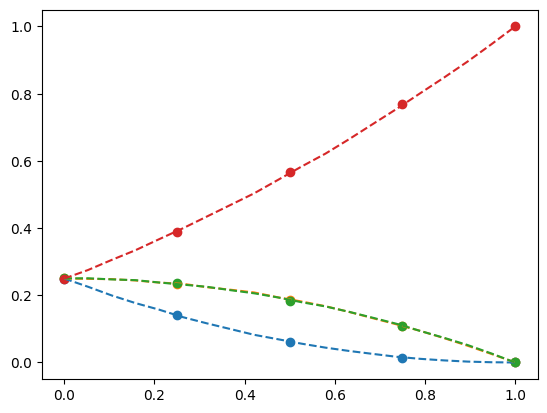

In [23]:
plt.scatter(probs,test_res[0,:])
plt.scatter(probs,test_res[1,:])
plt.scatter(probs,test_res[2,:])
plt.scatter(probs,test_res[3,:])
plt.plot(sim_probs,sim_res[0,:],linestyle='--')
plt.plot(sim_probs,sim_res[1,:],linestyle='--')
plt.plot(sim_probs,sim_res[2,:],linestyle='--')
plt.plot(sim_probs,sim_res[3,:],linestyle='--')
plt.show()

<h2>Running circuits on OQC Lucy:</h2>

1. Get decomposed circuits
2. Wrap in verbatim box
3. Disable qubit rewiring
4. Send

In [24]:
scale_factors = [1,3,5,7]

In [25]:
device_id = "aws_oqc_lucy"
device = device_wrapper(device_id)
print(device.metadata())

{'id': 'arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy', 'name': 'Lucy', 'provider': 'Oxford', 'vendor': 'AWS', 'numQubits': 8, 'deviceType': 'QPU', 'status': 'ONLINE', 'queueDepth': 1}


In [117]:
aws_device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
print(aws_device.name)

Lucy


Generated circuits for scale factors [1,3,5,7] below

In [37]:
circs_list = []
for sf in scale_factors:
    for i in range(probs.shape[0]):
        for j in range(4):
            j_str = bin(j)[2:].zfill(2)
            qc = zz_xx_pump(sys,env,probs[i],j_str)
            qc2 = fold_gates_at_random(qc,sf)
            qc3 = decompose_circuit(qc2)
            verbatim_qc = Circuit().add_verbatim_box(qc3)
            circs_list.append(verbatim_qc)

In [82]:
print(circs_list[8])

T  : |      0      |    1    |   2    |    3    |   4    |    5    |   6    |   7    |    8    |   9    |   10    |   11   |   12    |   13   |   14    |   15    |   16    |   17    |   18   |   19    |   20    |   21    |22 |   23    |   24    |   25    |26 |   27    |   28   |   29    |   30   |   31    |   32   |   33   |   34    |   35    |   36    |   37   |   38    |   39   |   40    |   41   |   42   |   43   |   44   |   45   |    46     |
                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
q4 : -StartVerbatim-X---------Rz(1.57)-V---------Rz(1.57)-Rz(-1.57)-----------------------------

<h3>Scale factor 1:</h3>

In [49]:
jobs_1 = []

In [50]:
for circ in circs_list[0:20]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_1.append(job.id)

In [ ]:
for circ in circs_list[0:20]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_1.append(job.id)

In [51]:
print(jobs_1)

['aws_oqc_lucy-contactmainakroy-qjob-81tzibczzru7qkx9a64s', 'aws_oqc_lucy-contactmainakroy-qjob-h3m2d1bqzlznxeomfq5p', 'aws_oqc_lucy-contactmainakroy-qjob-p3kfytwfujgerp04lkl4', 'aws_oqc_lucy-contactmainakroy-qjob-4zlr4oss6hetrmpicpmr', 'aws_oqc_lucy-contactmainakroy-qjob-fhf76jvwjsdfezic5ey3', 'aws_oqc_lucy-contactmainakroy-qjob-tkigu5sveph0cfh19r6y', 'aws_oqc_lucy-contactmainakroy-qjob-i1a5230pfvkkez1w9arq', 'aws_oqc_lucy-contactmainakroy-qjob-ta5d27wd0bzwngl8q3hj', 'aws_oqc_lucy-contactmainakroy-qjob-jca88as5rsefueh4s4rf', 'aws_oqc_lucy-contactmainakroy-qjob-9c5gewk43kb7o5eseb0x', 'aws_oqc_lucy-contactmainakroy-qjob-ohge9vzatknd7oxzc0ka', 'aws_oqc_lucy-contactmainakroy-qjob-uu3vhcb0bbe2ysm7vrnu', 'aws_oqc_lucy-contactmainakroy-qjob-sswzh9fzaz02c3dm3la0', 'aws_oqc_lucy-contactmainakroy-qjob-71fy91j3dps8ppl0mp5g', 'aws_oqc_lucy-contactmainakroy-qjob-zwiyxswh4pqle70je628', 'aws_oqc_lucy-contactmainakroy-qjob-xrxmlnbhg6xqqegkw1hs', 'aws_oqc_lucy-contactmainakroy-qjob-n19jakz2hcu9ursy3xk

<h3>Scale factor 3:</h3>

In [ ]:
jobs_3 = []

In [ ]:
for circ in circs_list[20:40]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_3.append(job.id)

In [ ]:
print(jobs_3)

<h3>Scale factor 5:</h3>

In [ ]:
jobs_5 = []

In [ ]:
for circ in circs_list[40:60]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_5.append(job.id)

In [ ]:
print(jobs_5)

<h3>Scale factor 7:</h3>

In [ ]:
jobs_7 = []

In [ ]:
for circ in circs_list[60:80]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_7.append(job.id)

In [ ]:
print(jobs_7)

<h2>Analysis:</h2>

In [53]:
res_1 = [job_wrapper(jobid).result()._result for jobid in jobs_1]

In [102]:
print(res_1[0].additional_metadata.oqcMetadata.compiledProgram)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg b[4];
rz(-1.5707963267948966) q[6];
rz(-3.141592653589793) q[5];
sx q[5];
rz(-3.141592653589793) q[5];
ecr q[6], q[5];
x q[6];
x q[4];
x q[7];
rz(1.5707963267948966) q[5];
rz(1.5707963267948966) q[4];
rz(1.5707963267948966) q[6];
rz(1.5707963267948966) q[7];
sx q[5];
sx q[4];
sx q[6];
sx q[7];
rz(1.5707963267948966) q[5];
rz(1.5707963267948966) q[4];
rz(1.5707963267948966) q[6];
rz(1.5707963267948966) q[7];
rz(-1.5707963267948966) q[4];
rz(-3.141592653589793) q[5];
sx q[5];
rz(-3.141592653589793) q[5];
ecr q[4], q[5];
x q[4];
rz(1.5707963267948966) q[6];
rz(1.5707963267948966) q[5];
rz(1.5707963267948966) q[4];
sx q[6];
sx q[5];
sx q[4];
rz(1.5707963267948966) q[6];
rz(1.5707963267948966) q[5];
rz(1.5707963267948966) q[4];
rz(-1.5707963267948966) q[7];
rz(-3.141592653589793) q[6];
sx q[6];
rz(-3.141592653589793) q[6];
ecr q[7], q[6];
x q[7];
rz(-1.5707963267948966) q[4];
rz(-3.141592653589793) q[5];
sx q[5];
rz(-3.141592653589793) q[5

In [113]:
out_1 = np.zeros(shape=(4,probs.shape[0]))
#For each i:i+4
for i in range(0,20,4):
    results = res_1[i:i+4]
    probs_f = np.zeros(4)
    for result in results:
        prob = result.measurement_probabilities
        for key,val in prob.items():
            probs_f[int(key[1:3],2)] += val
    out_1[:,i//4] = probs_f/4

In [114]:
print(out_1)

[[0.04931641 0.05151367 0.04418945 0.06298828 0.0703125 ]
 [0.15136719 0.13598633 0.14379883 0.12133789 0.11157227]
 [0.21704102 0.23583984 0.24365234 0.27514648 0.30834961]
 [0.58227539 0.57666016 0.56835938 0.54052734 0.50976562]]


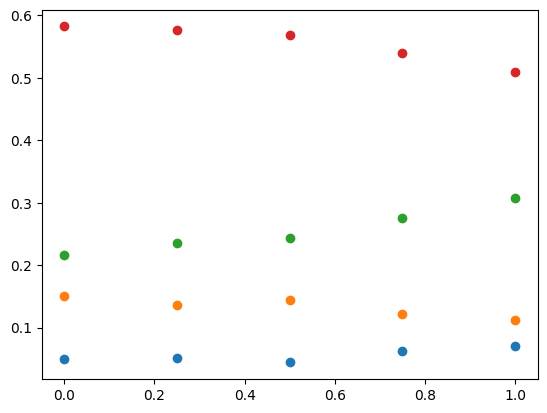

In [115]:
plt.scatter(probs,out_1[0,:])
plt.scatter(probs,out_1[1,:])
plt.scatter(probs,out_1[2,:])
plt.scatter(probs,out_1[3,:])
plt.show()